# D 100

Mrk 60
13 00 09.1410758256	+27 51 59.343513912

<img src="images/D100.png" width="400"/>

# MUSE

In [4]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt


# Open the FITS file and load data
with fits.open("DATA/D100/D100.fits") as hdul:
    hdul.info() 
    
    print('\n')
    header = hdul[1].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")

    # Load data
    cube = hdul[1].data 
    var = hdul[2].data 

# Generate the wavelength array
crval3 = header['CRVAL3']
dw = header['CD3_3'] 
channels = np.arange(0, header['NAXIS3'], 1)
w = header['CRVAL3'] + channels * header['CD3_3']  # Wavelength in Angstrom

dtheta_pix = abs(header['CD1_1'])     # angular resolution in deg    

# Define unit conversions
cube_units = 1e-20 / (dtheta_pix * 3600 )**2       # erg Angstrom-1 s-1 cm-2 arcsec-2
var_units = cube_units**2  

# Extract WCS parameters from the header
wcs = WCS(header)

# Extract image dimensions
naxis1, naxis2 = header['NAXIS1'], header['NAXIS2']

# Compute RA/Dec limits from pixel indices (setting spectral axis to 0)
ra_min, dec_min, _ = wcs.all_pix2world([[0, 0, 0]], 0)[0]       # Bottom-left corner
ra_max, dec_max, _ = wcs.all_pix2world([[naxis1, naxis2, 0]], 0)[0]  # Top-right corner

Filename: DATA/D100/D100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1537   ()      
  1  DATA          1 ImageHDU        44   (397, 399, 3682)   float32   
  2  STAT          1 ImageHDU        44   (397, 399, 3682)   float32   


XTENSION = IMAGE / IMAGE extension
BITPIX   = -32 / number of bits per data pixel
NAXIS    = 3 / number of data axes
NAXIS1   = 397 / length of data axis 1
NAXIS2   = 399 / length of data axis 2
NAXIS3   = 3682 / length of data axis 3
PCOUNT   = 0 / required keyword; must = 0
GCOUNT   = 1 / required keyword; must = 1
OBJECT   = D100 (DATA) / 
CRPIX1   = 213.079804891049 / Pixel coordinate of reference point
CRPIX2   = 189.602536232075 / Pixel coordinate of reference point
CD1_1    = -5.55555555555556e-05 / Coordinate transformation matrix element
CD1_2    = 0.0 / Coordinate transformation matrix element
CD2_1    = 0.0 / Coordinate transformation matrix element
CD2_2    = 5.55555555555556e-05 / Coordina

In [3]:
print(ra_min,ra_max)
print(dec_min,dec_max)

195.058514735212 195.03356555110395
27.858621441133888 27.88078826056309


In [ ]:
# spectra adding all spatial pixels

summed_spectra = np.nansum(cube, axis=(1, 2))
summed_var = np.nansum(var, axis=(1,2))

In [26]:
z =  0.0231

# Define important emission/absorption lines in galaxies
# Define important emission/absorption lines in galaxies
spectral_lines = {
    # Optical Lines
    "O II (Doublet)": 3727,
    "Hγ": 4340,
    "Hδ": 4102,
    "Hβ": 4861,
    "[O III] 4959": 4959,
    "[O III] 5007": 5007,
    "He II 4686": 4686,
    "He I 4471": 4471,
    "He I 5876": 5876,
    "Hα": 6563,
    "[N II] 6548": 6548,
    "[N II] 6583": 6583,
    "[S II] 6716": 6716,
    "[S II] 6731": 6731,
    "[Ar III] 7136": 7136,
    "[Fe II] 5159": 5159,

    # Calcium Lines
    "[Ca II] 8498": 8498,
    "[Ca II] 8542": 8542,
    "[Ca II] 8662": 8662,
    "Ca H": 3968,
    "Ca K": 3934,

    # Magnesium and Sodium Lines
    "Mg I 5175": 5175,
    "Na I D (Doublet)": 5890,  # Doublet at 5890 and 5896 Å
}
# Apply redshift correction to each spectral line
redshifted_lines = {name: wavelength * (1 + z) for name, wavelength in spectral_lines.items()}

# Define UBVRI filter wavelength ranges (in Angstrom)
filters = {
    "U": (3200, 4000),
    "B": (4000, 5000),
    "V": (5000, 6000),
    "R": (6000, 7000),
    "I": (7000, 9000),
}

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
plt.title("Integrated field spectrum")

plt.errorbar(w, summed_spectra*cube_units, yerr=np.sqrt(summed_var*var_units), fmt='o', color='red', ecolor='green', elinewidth=1.5, capsize=3, capthick=1.5,linestyle='-')

from scipy.ndimage import median_filter
continuum = median_filter(summed_spectra, size=101,mode="nearest")  # Choose an odd kernel size
plt.plot(w,continuum*cube_units)

plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [erg/s/cm^2/Å]")

min = np.min(summed_spectra*cube_units)
max = np.max(summed_spectra*cube_units)
# Add vertical shaded regions corresponding to the filters
for name, (wmin, wmax) in filters.items():
    plt.fill_betweenx([min, max], wmin, wmax, alpha=0.2, label=f"{name} filter")
    
# Add vertical dashed lines for spectral features
for name, wavelength in redshifted_lines.items():
    plt.axvline(wavelength, color="black", linestyle="dashed", alpha=0.7)
    plt.text(wavelength + 5, max * 0.8, name, 
             rotation=90, verticalalignment="bottom", fontsize=8, zorder=1, clip_on=True)

plt.xlim(4750.15,7500)
plt.xlim(6850,6900)
plt.xlim(6600,6750)

plt.show()

In [5]:
Ha_channel_inf = int((6700 - crval3)/dw)
Ha_channel_sup = int((6750 - crval3)/dw)
continuum_channel_inf = int((6620 - crval3)/dw)
continuum_channel_sup = int((6670 - crval3)/dw)

bandwidth = 50 # angstrom

integrated_Ha_units = cube_units * bandwidth   # integrating on wavelength

integrated_Ha_continuum = np.nansum(cube[Ha_channel_inf:Ha_channel_sup, :, :],axis=0) * integrated_Ha_units
integrated_continuum_near_Ha = np.nansum(cube[continuum_channel_inf:continuum_channel_sup, :, :], axis=0) * integrated_Ha_units

integrated_Ha = integrated_Ha_continuum - integrated_continuum_near_Ha


0.0011516705793158987


Text(195.04057583528964, 27.8595, '2 kpc')

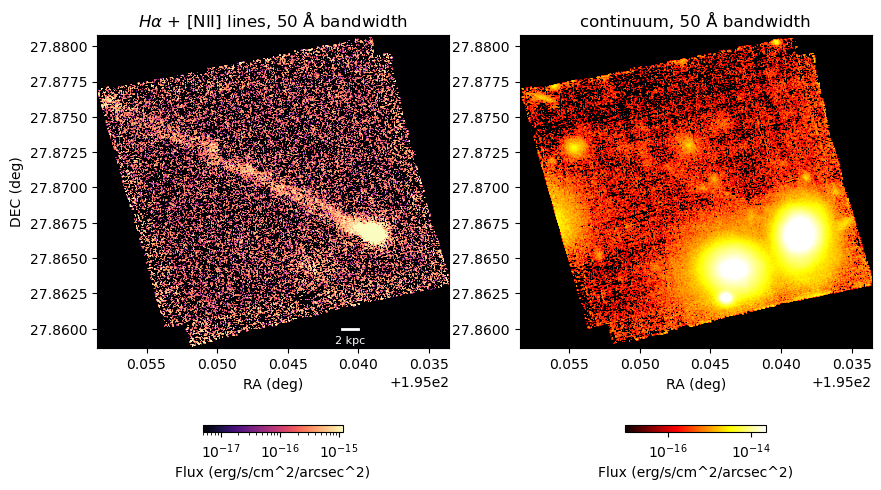

In [18]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size for better appearance
ax = ax.flatten()

# Plotting the integrated Ha
norm = LogNorm(np.nanquantile(integrated_Ha[integrated_Ha>0], 0.01), vmax=np.nanquantile(integrated_Ha, 0.99))
cmap = plt.cm.magma
cmap.set_bad(color='black')
im0 = ax[0].imshow(integrated_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[0].set_title("$H\\alpha$ + [NII] lines, 50 Å bandwidth")
ax[0].set_xlabel("RA (deg)")  
ax[0].set_ylabel("DEC (deg)")  

# Plotting the integrated continuum near Ha
norm = LogNorm(np.nanquantile(integrated_continuum_near_Ha[integrated_continuum_near_Ha>0], 0.01), vmax=np.nanquantile(integrated_continuum_near_Ha, 0.99))
cmap = plt.cm.hot
cmap.set_bad(color='black')
im1 = ax[1].imshow(integrated_continuum_near_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[1].set_title("continuum, 50 Å bandwidth")
ax[1].set_xlabel("RA (deg)")  
ax[1].set_ylabel("DEC (deg)")  

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Flux (erg/s/cm^2/arcsec^2)")  
cbar1.set_label("Flux (erg/s/cm^2/arcsec^2)")  





from astropy.cosmology import Planck18 as cosmo


#theta_arcsec = 1.0            # Angular size in arcseconds

# Get angular diameter distance in parsecs
z = 0.0231 
D_A = cosmo.angular_diameter_distance(z).to('pc').value
# Convert 2 kpc in angular distance
theta_arcsec = 2e3 / D_A / (np.pi / 648000)
theta_deg = theta_arcsec / 3600
#print(f"Angular diameter distance: {D_A:.2f} pc")
#print(f"Physical distance for {theta_arcsec}\" at z={z}: {d:.2f} pc")
print(theta_deg)

ax[0].plot([195+0.040,195+0.040+theta_deg], [27.8600,27.8600], color='white', lw=2)
ax[0].text(195+0.040+theta_deg / 2, 27.8595, "2 kpc", color='white',
        ha='center', va='top', fontsize=8)
    

In [22]:
# Create regions
import matplotlib.path as mpath
from matplotlib.patches import Rectangle


# Add ellipses
center = (195.038088,27.866484)  # Center of the galaxy (reference coordinates)
angle = - 90 # Angle of tilt in degrees
e = 0.5
width =  0.001
n=4

x = np.linspace(ra_min,ra_max)
m_semimajor_axis = np.tan(np.radians(angle))
y_semi =  m_semimajor_axis * (x - center[0]) + center[1]



# Generate the coordinate grid
y_coords, x_coords = np.meshgrid(np.linspace(dec_min, dec_max, integrated_Ha.shape[0]),
                                 np.linspace(ra_min, ra_max, integrated_Ha.shape[1]),
                                 indexing='ij')
# Flatten coordinates for easier processing
points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

# Rectangle


rect_width = 0.008  # Width in degrees
rect_height = 0.002  # Height in degrees
rect_angle = 23  # Tilt angle in degrees

rect = Rectangle((195+0.0385,27.8655), rect_width, rect_height, angle=rect_angle)


rect_path = rect.get_path().transformed(rect.get_transform())
polygon = mpath.Path(rect_path.vertices[:-1])  # Remove last duplicate vertex
inside_mask = polygon.contains_points(points)

rectangle_mask = inside_mask.reshape(integrated_Ha.shape)


masks_muse = []

for i in range(1, n):

    mask = np.zeros_like(integrated_Ha, dtype=bool)
    
    # external ellipse
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_ext = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # internal ellipse
    a = width * (i-1)                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_int = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # Create paths for the ellipses
    path_ext = mpath.Path(vertices_ext)
    path_int = mpath.Path(vertices_int)

    # Mask points within the external but outside the internal ellipse
    mask_ext = path_ext.contains_points(points).reshape(mask.shape)
    mask_int = path_int.contains_points(points).reshape(mask.shape)
    
    mask |= (mask_ext & ~mask_int & ~rectangle_mask)
    
    masks_muse.append(mask)
    

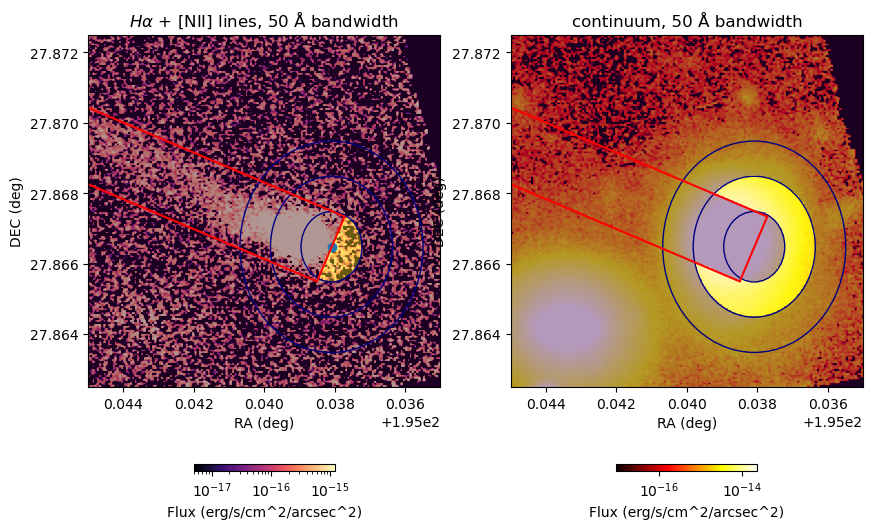

In [23]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size for better appearance
ax = ax.flatten()

norm = LogNorm(np.nanquantile(integrated_Ha[integrated_Ha>0], 0.01), vmax=np.nanquantile(integrated_Ha, 0.99))
cmap = plt.cm.magma
cmap.set_bad(color='black')
im0 = ax[0].imshow(integrated_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[0].set_title("$H\\alpha$ + [NII] lines, 50 Å bandwidth")
ax[0].set_xlabel("RA (deg)")  
ax[0].set_ylabel("DEC (deg)")  

norm = LogNorm(np.nanquantile(integrated_continuum_near_Ha[integrated_continuum_near_Ha>0], 0.01), vmax=np.nanquantile(integrated_continuum_near_Ha, 0.99))
cmap = plt.cm.hot
cmap.set_bad(color='black')
im1 = ax[1].imshow(integrated_continuum_near_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[1].set_title("continuum, 50 Å bandwidth")
ax[1].set_xlabel("RA (deg)")  
ax[1].set_ylabel("DEC (deg)")  

ax[0].scatter(195.038088,27.866484)

center = (195.038088,27.866484)  # Center of the galaxy (reference coordinates)
angle = - 90 # Angle of tilt in degrees
e = 0.5
width =  0.001
n=4
for i in range(1, n):
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   
    
    for k in range(2):
        ellipse = Ellipse(center, a*2, b*2, angle=angle, edgecolor='navy', facecolor='none')
        ax[k].add_patch(ellipse)

# Define rectangle properties
rect_width = 0.008  # Width in degrees
rect_height = 0.002  # Height in degrees
rect_angle = 23  # Tilt angle in degrees

# Create and add the rectangle to both subplots
for k in range(2):
    rect = Rectangle((195+0.0385,27.8655), 
                     rect_width, rect_height, 
                     angle=rect_angle, edgecolor='red', facecolor='none', linewidth=1.5)
    ax[k].add_patch(rect)


ax[0].set_xlim(195+0.045,195+0.035)
ax[0].set_ylim(27.8625,27.8725)
ax[1].set_xlim(195+0.045,195+0.035)
ax[1].set_ylim(27.8625,27.8725)

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Flux (erg/s/cm^2/arcsec^2)")  
cbar1.set_label("Flux (erg/s/cm^2/arcsec^2)")

ax[0].imshow(masks_muse[0], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]
ax[1].imshow(masks_muse[1], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]


plt.show()


In [24]:
spectra_muse = []
for i,mask in enumerate(masks_muse):
    n = len(mask[mask==True])
    # Sum the spectra for the region defined by the mask (sum over the spatial axes)
    spectra_region = np.nansum(cube[:, mask], axis=1) / n  * cube_units
    var_region = np.nansum(var[:, mask], axis=1) / n**2  * var_units
    snr = spectra_region / np.sqrt(var_region)
    spectra_muse.append([spectra_region,var_region,snr])

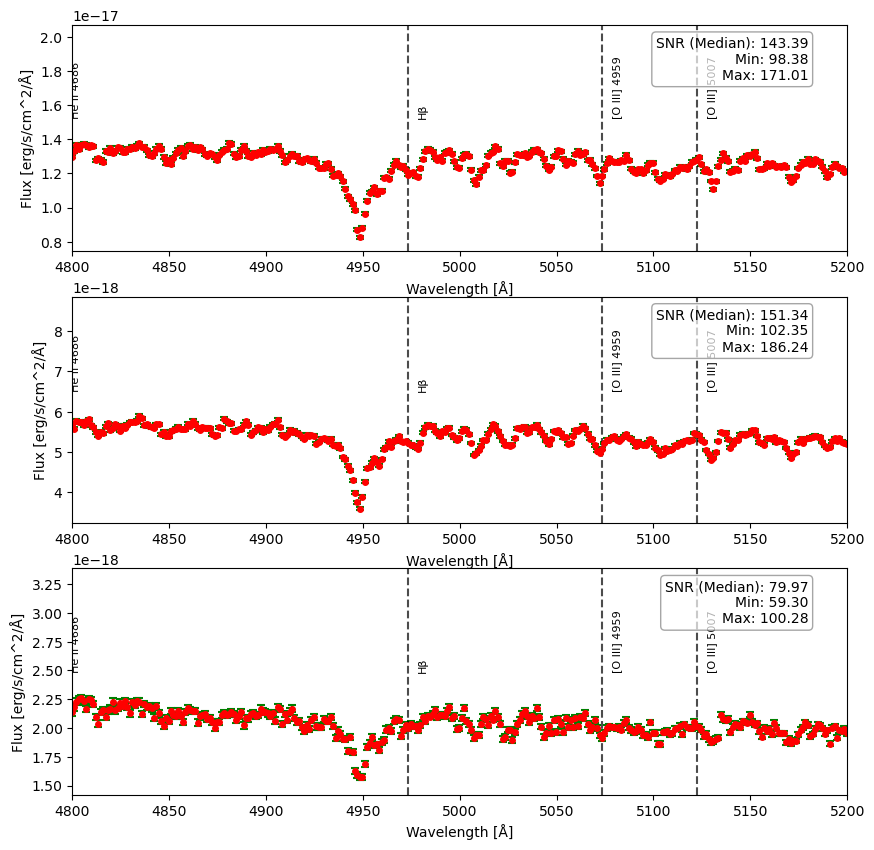

In [28]:
fig,ax= plt.subplots(3,1,figsize=(10,10))
ax = ax.flatten()

for i,s in enumerate(spectra_muse):
    spectra_region = spectra_muse[i][0]
    var_region = spectra_muse[i][1]
    snr = spectra_muse[i][2]
    ax[i].errorbar(w, spectra_region, yerr=np.sqrt(var_region), 
                   ms=4,fmt='o', color='red', ecolor='green', elinewidth=1.5, capsize=3, capthick=1.5)

    #xinf,xsup = 6600, 6800   
    xinf,xsup = 4800,5200   
    #xinf,xsup = 5800,6000
    #xinf,xsup = 7400,7500
    #xinf,xsup = 4500,8000
    ax[i].set_xlim(xinf,xsup)
    mask = (w >= xinf) & (w <= xsup)
    y_min,y_max = np.nanmin(spectra_region[mask]),np.nanmax(spectra_region[mask])
    ax[i].set_ylim(0.9 * y_min, 1.5 * y_max)
    
    for name, wavelength in redshifted_lines.items():
        ax[i].axvline(wavelength, color="black", linestyle="dashed", alpha=0.7)
        ax[i].text(wavelength + 5, y_max * 1.1, name, 
                   rotation=90, verticalalignment="bottom", fontsize=8, zorder=1, clip_on=True)

    snr_median = np.nanmedian(snr[mask])
    snr_min = np.nanmin(snr[mask])
    snr_max = np.nanmax(snr[mask])
    
    # Add text to the upper right of the plot
    ax[i].text(
        0.95, 0.95, 
        f"SNR (Median): {snr_median:.2f}\nMin: {snr_min:.2f}\nMax: {snr_max:.2f}",
        ha='right', va='top', 
        transform=ax[i].transAxes, 
        fontsize=10, bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white', alpha=0.7)
    )
    
    ax[i].set_xlabel("Wavelength [Å]")
    ax[i].set_ylabel("Flux [erg/s/cm^2/Å]")
    #ax[i].set_title(f"Spectrum for region {i:.0f}")

plt.show()




# HST

In [14]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

with fits.open("DATA/D100_f814w_f475w_sci.fits") as hdul:
    #hdul.info()
    print(hdul[0].header.tostring(sep="\n"))
    data = hdul[0].data
    #print(hdul[1].header)
    #cube = hdul[1].data


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 5334 / length of data axis 1                          
NAXIS2  =                 5281 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-05-26T19:11:50' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = -1.3888888888888E-

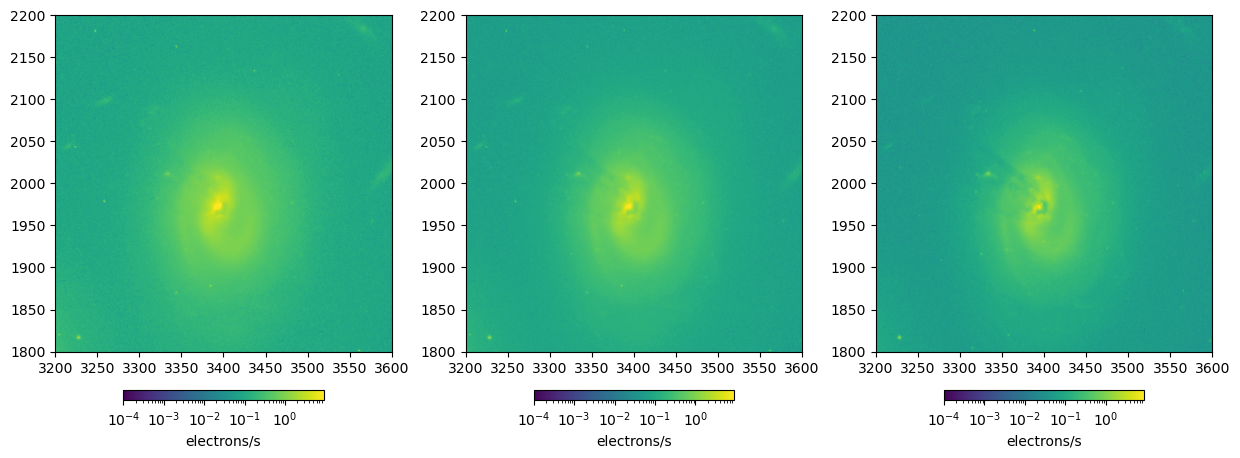

In [21]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Define vmin and vmax for logarithmic normalization (avoid zero values)
vmin = 1e-2 #np.nanpercentile(data, 0.001)  # Avoid zero for log scale
vmax = np.nanpercentile(data, 99.999)

# Use LogNorm for better contrast visualization
im1 = ax[0].imshow(data[0], origin='lower', cmap='viridis', norm=LogNorm(vmin, vmax))
im2 = ax[1].imshow(data[1], origin='lower', cmap='viridis', norm=LogNorm(vmin, vmax))
im3 = ax[2].imshow(data[2], origin='lower', cmap='viridis', norm=LogNorm(vmin, vmax))

# Add colorbars
fig.colorbar(im1, ax=ax[0], orientation='horizontal', label='electrons/s', pad=0.1, fraction=0.026)
fig.colorbar(im2, ax=ax[1], orientation='horizontal', label='electrons/s', pad=0.1, fraction=0.026)
fig.colorbar(im3, ax=ax[2], orientation='horizontal', label='electrons/s', pad=0.1, fraction=0.026)

for i in range(3):
    ax[i].set_xlim(3200,3600)
    ax[i].set_ylim(1800,2200)

(1800.0, 2200.0)

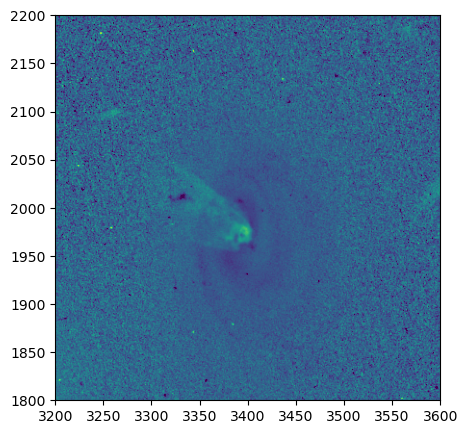

In [28]:
fig, ax = plt.subplots(figsize=(15,5))

#ax[0].set_title("V band, continuum + lines")
im1 = ax.imshow(data[0]/data[1], origin='lower', cmap='viridis',clim=[0.99,2])
ax.set_xlim(3200,3600)
ax.set_ylim(1800,2200)

In [33]:
with fits.open("DATA/D100_f275w_drz.fits") as hdul:
    hdul.info()
    #print(hdul[0].header.tostring(sep="\n"))
    #print(hdul[1].header.tostring(sep="\n"))
    
    print(hdul[2].header.tostring(sep="\n"))
    sci = hdul[1].data
    #print(hdul[1].header)
    #cube = hdul[1].data


Filename: DATA/D100_f275w_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     910   ()      
  1  SCI           1 ImageHDU        88   (4462, 4805)   float32   
  2  WHT           1 ImageHDU        47   (4462, 4805)   float32   
  3  CTX           1 ImageHDU        42   (4462, 4805)   int32   
  4  HDRTAB        1 BinTableHDU    557   6R x 274C   [9A, 3A, J, D, D, D, D, D, D, D, D, D, D, D, D, J, 4A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, J, J, 8A, 23A, D, D, D, D, J, J, 8A, 23A, 9A, 18A, 4A, J, D, D, D, J, J, J, J, 23A, D, D, D, D, J, J, 4A, 3A, 4A, J, D, D, D, 23A, 1A, J, D, D, D, 4A, 1A, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 4A, 3A, 3A, 4A, 8A, 7A, D, J, D, 6A, 9A, 8A, D, D, 4A, 18A, 3A, J, 5A, 3A, D, 10A, 8A, 8A, 23A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, J, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, J, J, J, J, D, 3A, J, D, 5A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 

(1700.0, 2050.0)

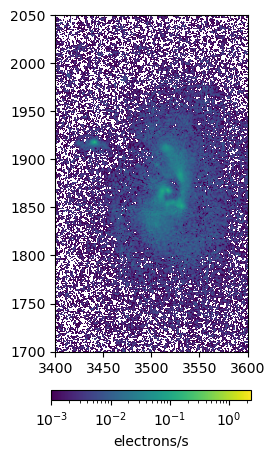

In [42]:
fig, ax = plt.subplots(figsize=(5,5))

vmin = 1e-3 #np.nanpercentile(data, 0.001)  # Avoid zero for log scale
vmax = np.nanpercentile(sci, 99.999)

#ax[0].set_title("V band, continuum + lines")
im1 = ax.imshow(sci, origin='lower', cmap='viridis',norm=LogNorm(vmin, vmax))
fig.colorbar(im1, ax=ax, orientation='horizontal', label='electrons/s', pad=0.1, fraction=0.026)
ax.set_xlim(3400,3600)
ax.set_ylim(1700,2050)


# GALEX

In [4]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt

# Near UV

with fits.open("DATA/Coma_coadd-int_nuv.fits") as hdul:
    hdul.info()  # Shows a summary of the FITS file

    print('\n')
    header = hdul[0].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")  

    image_nuv = hdul[0].data

# Far UV

with fits.open("DATA/Coma_coadd-int_fuv.fits") as hdul:
    #hdul.info()  # Shows a summary of the FITS file
    image_fuv = hdul[0].data


dtheta_pix = abs(header['CD1_1'])     # angular resolution in deg   

# Extract WCS parameters from the header
wcs = WCS(header)

# Extract image dimensions
naxis1, naxis2 = header['NAXIS1'], header['NAXIS2']

Filename: DATA/Coma_coadd-int_nuv.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (10750, 9900)   float32   


SIMPLE   = True / file does conform to FITS standard
BITPIX   = -32 / number of bits per data pixel
NAXIS    = 2 / number of data axes
NAXIS1   = 10750 / length of data axis 1
NAXIS2   = 9900 / length of data axis 2
EXTEND   = True / FITS dataset may contain extensions
COMMENT  =   FITS (Flexible Image Transport System) format is defined in 'Astronomy / 
COMMENT  =   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H / 
EQUINOX  = 2000.0 / Mean equinox
RADESYS  = ICRS / Astrometric system
CTYPE1   = RA---TAN / WCS projection type for this axis
CUNIT1   = deg / Axis unit
CRVAL1   = 195.0540528935 / World coordinate on this axis
CRPIX1   = 5375.5 / Reference pixel on this axis
CD1_1    = -0.000416666676756 / Linear projection matrix
CD1_2    = 0.0 / Linear projection matrix
CTYPE2   = DEC--TAN / WCS 

In [5]:
ra_min_cut = 195.058514735212 
ra_max_cut = 195.03356555110395

dec_min_cut = 27.858621441133888 
dec_max_cut = 27.88078826056309

x_min_cut,y_min_cut = wcs.all_world2pix([[ra_min_cut,dec_min_cut]], 0)[0]
x_max_cut,y_max_cut = wcs.all_world2pix([[ra_max_cut,dec_max_cut]], 0)[0]

#print(x_min_cut,x_max_cut)
#print(y_min_cut,y_max_cut)

image_nuv_cut = image_nuv[int(y_min_cut):int(y_max_cut),int(x_min_cut):int(x_max_cut)]
image_fuv_cut = image_fuv[int(y_min_cut):int(y_max_cut),int(x_min_cut):int(x_max_cut)]

In [6]:

Wave_pivot_fuv = 1524 
#AG = args.ebv*MW_extinction(Wave_pivot)  #8.24

ZP_fuv = 18.82
ZP_err_fuv = 0.05

C = ZP_fuv 
conversion_factor_fuv = 10**-C

units_fuv = conversion_factor_fuv / (dtheta_pix * 3600)**2

Wave_pivot_nuv = 2297 

ZP_nuv = 20.08 
ZP_err_nuv = 0.05

C = ZP_nuv 
conversion_factor_nuv = 10**-C

units_nuv = conversion_factor_nuv / (dtheta_pix * 3600)**2

image_nuv_phys = image_nuv_cut * units_nuv
image_fuv_phys = image_fuv_cut * units_fuv

In [9]:
# Create regions
import matplotlib.path as mpath
from matplotlib.patches import Rectangle

# Add ellipses
center = (195.038088,27.866484)  # Center of the galaxy (reference coordinates)
angle = - 90 # Angle of tilt in degrees
e = 0.5
width =  0.001
n=4

x = np.linspace(ra_min_cut,ra_max_cut)
m_semimajor_axis = np.tan(np.radians(angle))
y_semi =  m_semimajor_axis * (x - center[0]) + center[1]



# Generate the coordinate grid
y_coords, x_coords = np.meshgrid(np.linspace(dec_min_cut, dec_max_cut, image_nuv_cut.shape[0]),
                                 np.linspace(ra_min_cut, ra_max_cut, image_nuv_cut.shape[1]),
                                 indexing='ij')
# Flatten coordinates for easier processing
points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

# Rectangle


rect_width = 0.008  # Width in degrees
rect_height = 0.002  # Height in degrees
rect_angle = 23  # Tilt angle in degrees

rect = Rectangle((195+0.0385,27.8655), rect_width, rect_height, angle=rect_angle)


rect_path = rect.get_path().transformed(rect.get_transform())
polygon = mpath.Path(rect_path.vertices[:-1])  # Remove last duplicate vertex
inside_mask = polygon.contains_points(points)

rectangle_mask = inside_mask.reshape(image_nuv_cut.shape)


masks_galex = []

for i in range(1, n):

    mask = np.zeros_like(image_nuv_cut, dtype=bool)
    
    # external ellipse
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_ext = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # internal ellipse
    a = width * (i-1)                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_int = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # Create paths for the ellipses
    path_ext = mpath.Path(vertices_ext)
    path_int = mpath.Path(vertices_int)

    # Mask points within the external but outside the internal ellipse
    mask_ext = path_ext.contains_points(points).reshape(mask.shape)
    mask_int = path_int.contains_points(points).reshape(mask.shape)
    
    mask |= (mask_ext & ~mask_int & ~rectangle_mask)
    
    masks_galex.append(mask)
    

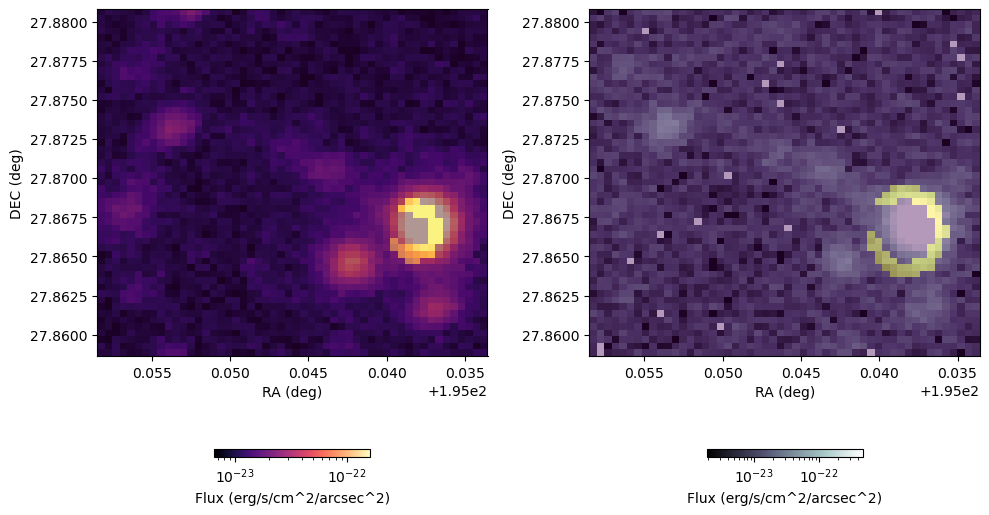

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size for better appearance
ax = ax.flatten()

norm = LogNorm(np.nanquantile(image_nuv_phys[image_nuv_phys>0], 0.01), vmax=np.nanquantile(image_nuv_phys, 0.99))

# nuv
im0 = ax[0].imshow(image_nuv_phys, origin='lower', extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], cmap='magma', norm=norm) 
ax[0].set_xlabel("RA (deg)")  
ax[0].set_ylabel("DEC (deg)")  

# fuv
norm = LogNorm(np.nanquantile(image_fuv_phys[image_fuv_phys>0], 0.01), vmax=np.nanquantile(image_fuv_phys, 0.99))
im1 = ax[1].imshow(image_fuv_phys, origin='lower', extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], cmap='bone', norm=norm)
ax[1].set_xlabel("RA (deg)")  
ax[1].set_ylabel("DEC (deg)")  

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Flux (erg/s/cm^2/arcsec^2)")  
cbar1.set_label("Flux (erg/s/cm^2/arcsec^2)")  

######

# Create ellipses and add them to the plot
#for i in range(1, n):
#    a = width * i                # semimajor axis
#    b = a * np.sqrt(1-e**2)   
    
#    for k in range(2):
#        ellipse = Ellipse(center, a*2, b*2, angle=angle, edgecolor='navy', facecolor='none')
#        ax[k].add_patch(ellipse)
        #x_text = center[0] + a * np.cos(np.radians(angle)) - 5
        #y_text = m_semimajor_axis * (x_text - center[0]) + center[1]
        #ax[k].text(x_text,y_text, i, fontsize=15, zorder=1, clip_on=True,c='navy')


#ax[0].scatter(center[0], center[1], marker='+', c='red')
#ax[1].scatter(center[0], center[1], marker='+', c='red')
#ax[0].plot(x,y_semi,linestyle=':',c='red')
#ax[1].plot(x,y_semi,linestyle=':',c='red')
#ax[0].plot(x,y_line,linestyle=':',c='red')
#ax[1].plot(x,y_line,linestyle=':',c='red')

ax[0].imshow(masks_galex[1], extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]
ax[1].imshow(masks_galex[2], extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]

for k in range(2):
    ax[k].set_xlim(ra_min_cut,ra_max_cut)
    ax[k].set_ylim(dec_min_cut,dec_max_cut)
    #ax[k].set_xlim(194.5+0.03,194.5+0.022)
    #ax[k].set_ylim(28.235,28.243)
    #ax[k].grid()


# Adjusting layout to make it fit better
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the tight_layout to leave space for colorbars
plt.show()

